In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import scale, label_binarize
import decimal
import statsmodels.api as sm
from statsmodels.discrete import discrete_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
%matplotlib inline
pd.set_option('display.max_columns', None)

In [23]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    for i in range(n_classes): 
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for position %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
#     sns.despine()
    plt.show()

In [24]:
df = pd.read_csv("sample_all_NoConv.csv")
df_testing = df[df['SeasonId'] == 2020]
df_testing = df[df['RoundId'] < 5]
df_testing['RoundId'] = 1
df_testing = df_testing.rename({'RoundId': 'FirstSeasonHalf'}, axis = 1)

for i in range(13):
    df.loc[df['RoundId'] == i, 'RoundId'] = 1
for i in range(13, 29):
    df.loc[df['RoundId'] == i, 'RoundId'] = 0
df = df.rename({'RoundId': 'FirstSeasonHalf'}, axis = 1)
df = df.drop('Unnamed: 0', axis = 1)

<ipython-input-24-ce1a9376f3d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing['RoundId'] = 1


In [25]:
df2019 = df[df['SeasonId'] == 2019]
df2020 = df[df['SeasonId'] == 2020]
df2019_2020 = pd.concat([df2019, df2020])
df2021 = df[df['SeasonId'] == 2021]
df2019_2020

,SeasonId,FirstSeasonHalf,PositionId,Captain,ElapsedMillisecs,Tackle,Points,PossessionSecs,TotalPossessionSecs,PBNS,RCVS,MACS,MACD,MBCS,MBCD,OADS,TKED,MKRS,MKRD,TRCS,Tackle_sum,Pass_sum,Dummy_pass_sum,C,L,NL,NR,R,SL,SR,Goal_CVOK,Goal_FGOK,Goal_PGOK,Goal_TRY,Weather_2,Weather_3,Weather_4,Weather_1040,Half_1,Half_2,Half_3,Half_4,Missed_convert,TRY_Convert
0,2019,1,1.0,1,1771200,0,2.0,537.82,1142.02,3,7,3,8,3,8,3,3,6,6,0,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
1,2019,1,2.0,0,290720,0,2.0,991.28,1855.64,1,7,3,8,3,8,4,2,4,4,0,7,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,2019,1,0.0,0,486880,6,4.0,1068.54,1982.58,3,7,3,8,3,8,3,3,6,6,2,11,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
3,2019,1,0.0,0,1379560,3,4.0,1313.64,2368.24,3,6,2,4,2,4,2,3,5,5,2,8,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
4,2019,1,0.0,0,1919840,4,4.0,1554.06,2752.46,1,8,2,6,2,6,6,1,2,2,1,5,2,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,2020,0,2.0,0,377920,1,4.0,944.56,1803.42,1,9,1,3,1,3,4,1,2,2,4,4,6,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
1562,2020,0,2.0,0,1014600,3,4.0,966.84,2052.58,1,5,1,3,1,3,3,1,2,2,3,4,6,2,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
1563,2020,0,2.0,0,2268200,3,4.0,1311.96,2806.20,2,6,1,3,1,3,1,2,4,4,3,9,2,2,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
1564,2020,0,2.0,0,2718480,4,4.0,1457.32,2955.32,2,10,2,3,2,3,1,1,2,2,0,11,4,3,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0


# SVM (2019,2020)

In [74]:
X = scale(df2019.drop(['PositionId'], axis='columns'))
y = df2019.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2020 = df2020[df2020['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2020.drop(['PositionId'], axis='columns'))
y_test = FirstH_2020.PositionId

In [75]:
parem = {'C':[0.01, 0.5, 1, 10, 100],
         'gamma':['scale', 1, 0.1, 0.01, 0.001, 0.0001],
         'kernel':['rbf', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        77
         1.0       0.52      0.25      0.34       101
         2.0       0.62      0.93      0.74       254

    accuracy                           0.61       432
   macro avg       0.38      0.39      0.36       432
weighted avg       0.49      0.61      0.52       432

[[  0   6  71]
 [  1  25  75]
 [  0  17 237]]


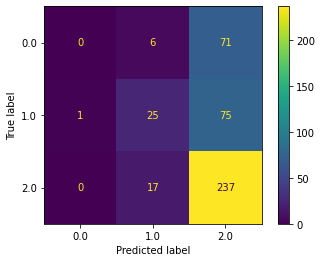

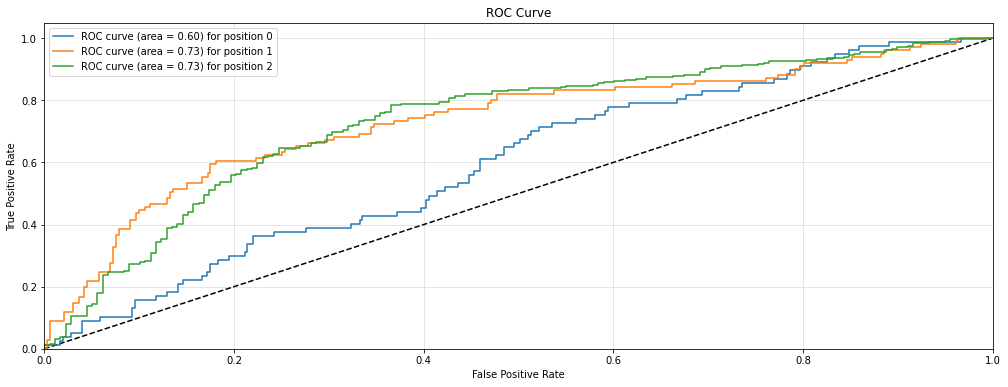

In [76]:
svm = SVC(C=1, gamma=0.01, kernel='sigmoid', probability=True)
svm.fit(X, y)
pred = svm.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(svm, X_test, y_test)
plt.show()
plot_multiclass_roc(svm, X_test, y_test, 3, figsize=(17, 6))

# SVM (2020, 2021)


In [80]:
X = scale(df2020.drop(['PositionId'], axis='columns'))
y = df2020.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2021 = df2021[df2021['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2021.drop(['PositionId'], axis='columns'))
y_test = FirstH_2021.PositionId

In [81]:
parem = {'C':[0.01, 0.5, 1, 10, 100],
         'gamma':['scale', 1, 0.1, 0.01, 0.001, 0.0001],
         'kernel':['rbf', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        64
         1.0       0.47      0.27      0.34        64
         2.0       0.65      0.92      0.76       221

    accuracy                           0.63       349
   macro avg       0.37      0.40      0.37       349
weighted avg       0.50      0.63      0.55       349

[[  0   2  62]
 [  0  17  47]
 [  0  17 204]]


C:\Users\parry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\parry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\parry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


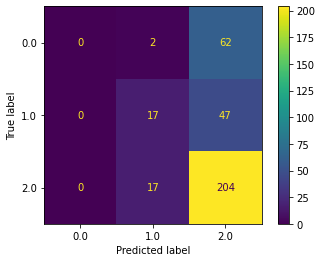

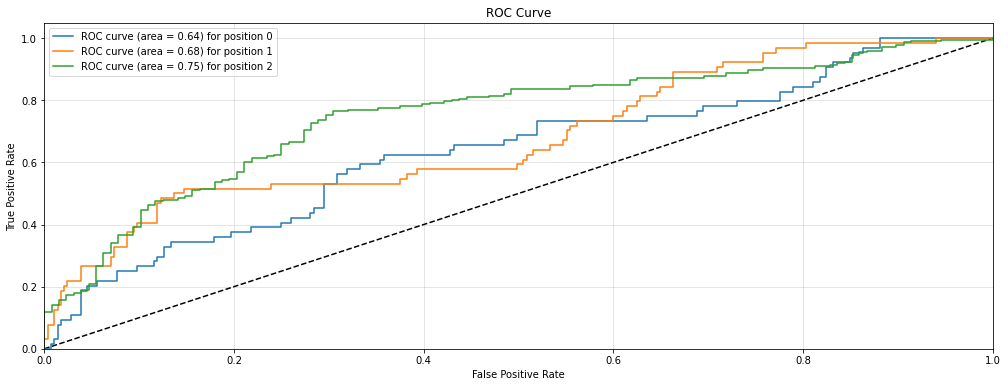

In [82]:
svm = SVC(C=1, gamma=0.01, kernel='sigmoid', probability=True)
svm.fit(X, y)
pred = svm.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(svm, X_test, y_test)
plt.show()
plot_multiclass_roc(svm, X_test, y_test, 3, figsize=(17, 6))

# Logistic Regression (2019, 2020)

In [83]:
X = scale(df2019.drop(['PositionId'], axis='columns'))
y = df2019.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2020 = df2020[df2020['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2020.drop(['PositionId'], axis='columns'))
y_test = FirstH_2020.PositionId

In [84]:
parem = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'C':[100, 10, 1, 0.1, 0.01]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'C': 0.01, 'solver': 'newton-cg'}


              precision    recall  f1-score   support

         0.0       0.33      0.17      0.22        77
         1.0       0.49      0.43      0.46       101
         2.0       0.70      0.84      0.77       254

    accuracy                           0.62       432
   macro avg       0.51      0.48      0.48       432
weighted avg       0.59      0.62      0.60       432

[[ 13  16  48]
 [ 16  43  42]
 [ 11  29 214]]


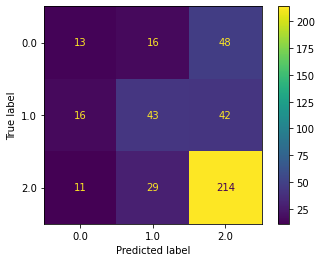

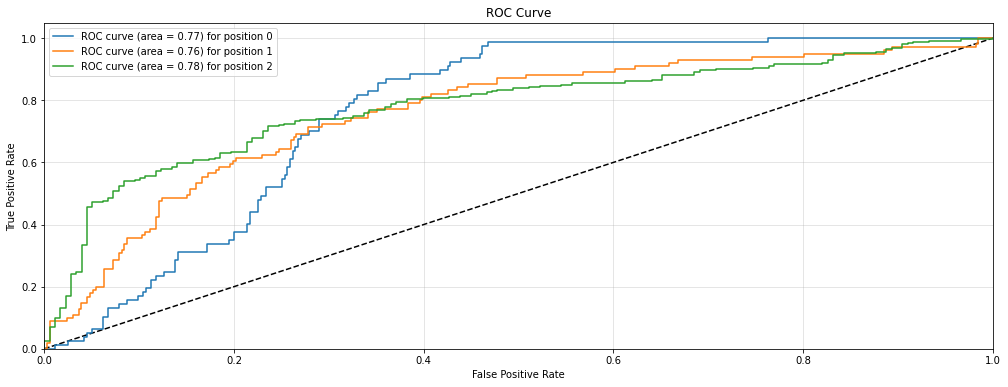

In [85]:
logistic = LogisticRegression(C=0.1, solver='liblinear')
logistic.fit(X, y)
pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(logistic, X_test, y_test)
plt.show()
plot_multiclass_roc(logistic, X_test, y_test, 3, figsize=(17, 6))

# Logistic Regression (2020, 2021)

In [86]:
X = scale(df2020.drop(['PositionId'], axis='columns'))
y = df2020.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2021 = df2021[df2021['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2021.drop(['PositionId'], axis='columns'))
y_test = FirstH_2021.PositionId

In [87]:
parem = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'C':[100, 10, 1, 0.1, 0.01]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'C': 0.1, 'solver': 'liblinear'}


              precision    recall  f1-score   support

         0.0       0.44      0.28      0.34        64
         1.0       0.45      0.52      0.48        64
         2.0       0.77      0.82      0.79       221

    accuracy                           0.66       349
   macro avg       0.55      0.54      0.54       349
weighted avg       0.65      0.66      0.65       349

[[ 18  14  32]
 [  9  33  22]
 [ 14  26 181]]


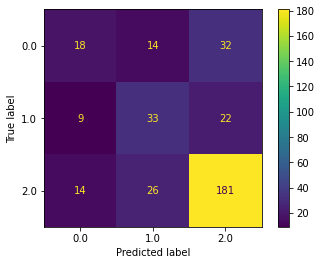

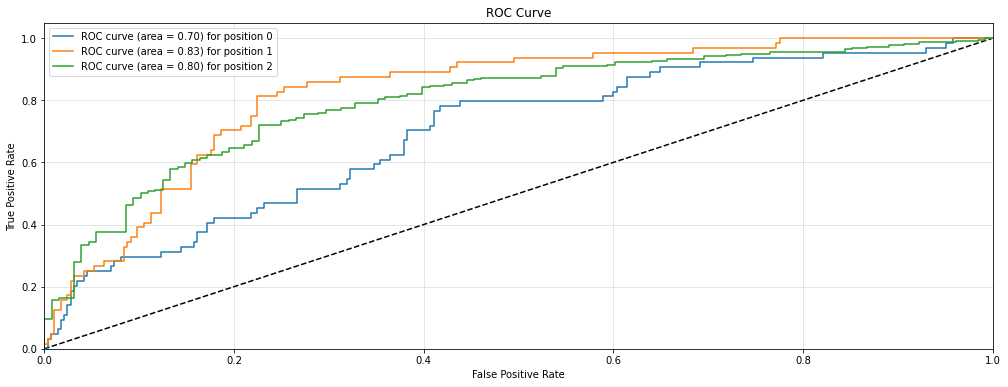

In [88]:
logistic = LogisticRegression(C=0.1, solver='liblinear')
logistic.fit(X, y)
pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(logistic, X_test, y_test)
plt.show()
plot_multiclass_roc(logistic, X_test, y_test, 3, figsize=(17, 6))

# Random Forest (2019, 2020)

In [101]:
X = scale(df2019.drop(['PositionId'], axis='columns'))
y = df2019.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2020 = df2020[df2020['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2020.drop(['PositionId'], axis='columns'))
y_test = FirstH_2020.PositionId

In [102]:
parem = {'n_estimators': [10, 100, 1000],
         'max_features': ['sqrt', 'log2']}
grid = GridSearchCV(RandomForestClassifier(), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'max_features': 'sqrt', 'n_estimators': 1000}


              precision    recall  f1-score   support

         0.0       0.31      0.06      0.11        77
         1.0       0.46      0.30      0.36       101
         2.0       0.65      0.89      0.75       254

    accuracy                           0.61       432
   macro avg       0.47      0.42      0.41       432
weighted avg       0.54      0.61      0.54       432

[[  5  14  58]
 [  5  30  66]
 [  6  21 227]]


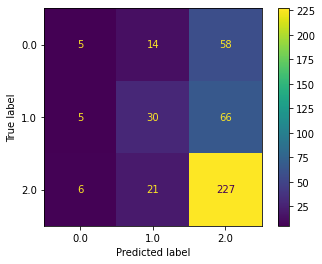

In [103]:
rf = RandomForestClassifier(max_features='log2', n_estimators=1000)
rf.fit(X, y)
pred = rf.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(rf, X_test, y_test)
plt.show()

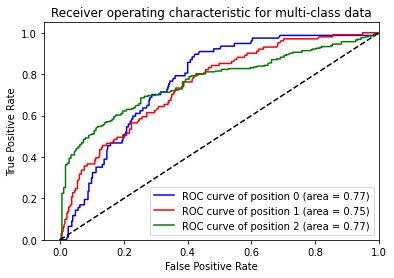

In [104]:
a = label_binarize(y, classes=[0, 1, 2])
b = label_binarize(y_test, classes=[0, 1, 2])
n_classes = a.shape[1]

classifier = OneVsRestClassifier(RandomForestClassifier(max_features='log2', n_estimators=100, random_state=123))
y_score = classifier.fit(X, y).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of position {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Random Forest (2020, 2021)

In [105]:
X = scale(df2020.drop(['PositionId'], axis='columns'))
y = df2020.PositionId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

FirstH_2021 = df2021[df2021['FirstSeasonHalf'] == 1]
X_test = scale(FirstH_2021.drop(['PositionId'], axis='columns'))
y_test = FirstH_2021.PositionId

In [106]:
parem = {'n_estimators': [10, 100, 1000],
         'max_features': ['sqrt', 'log2']}
grid = GridSearchCV(RandomForestClassifier(), param_grid=parem, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'max_features': 'sqrt', 'n_estimators': 1000}


              precision    recall  f1-score   support

         0.0       0.52      0.17      0.26        64
         1.0       0.51      0.44      0.47        64
         2.0       0.71      0.88      0.79       221

    accuracy                           0.67       349
   macro avg       0.58      0.50      0.50       349
weighted avg       0.64      0.67      0.63       349

[[ 11   8  45]
 [  2  28  34]
 [  8  19 194]]


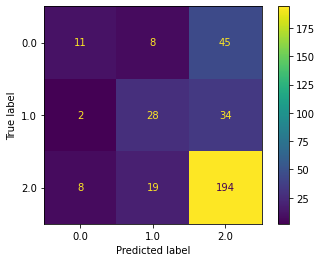

In [107]:
rf = RandomForestClassifier(max_features='log2', n_estimators=1000)
rf.fit(X, y)
pred = rf.predict(X_test)
print(classification_report(y_test, y_pred=pred))
print(confusion_matrix(y_test, y_pred=pred))
matrix = plot_confusion_matrix(rf, X_test, y_test)
plt.show()

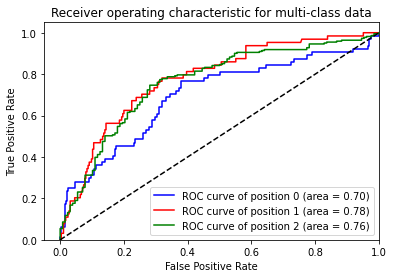

In [108]:
a = label_binarize(y, classes=[0, 1, 2])
b = label_binarize(y_test, classes=[0, 1, 2])
n_classes = a.shape[1]

classifier = OneVsRestClassifier(RandomForestClassifier(max_features='log2', n_estimators=1000, random_state=123))
y_score = classifier.fit(X, y).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of position {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()